# Import Modules

In [ ]:
!git clone https://github.com/dariush-bahrami/gravity.optimizer.git

Cloning into 'gravity.optimizer'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 208 (delta 107), reused 157 (delta 56), pack-reused 0
Receiving objects: 100% (208/208), 3.27 MiB | 12.27 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [ ]:
# !rm -R /content/gravity.optimizer

In [ ]:
import sys
sys.path.append('/content/gravity.optimizer')
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
plt.style.use('dark_background')
import gravity

Found GPU at: /device:GPU:0


# Optimizer Definition

In [ ]:
class Gravity(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.1, alpha=0.01, beta=0.9, name="Gravity", **kwargs):
        super(Gravity, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('alpha', alpha)
        self._set_hyper('beta', beta)
        self.epsilon = 1e-7
    def _create_slots(self, var_list):
        alpha = self._get_hyper("alpha")
        stddev = alpha/self.learning_rate
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=stddev, seed=None)
        # initializer = 'zeros'
        for var in var_list:
            self.add_slot(var, "velocity", initializer=initializer)

    @tf.function
    def _resource_apply_dense(self, grad, var):
        # Get Data
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        beta_hat = self._get_hyper("beta", var_dtype)
        t = tf.cast(self.iterations, float)
        beta = (beta_hat*t + 1 )/(t + 2)
        velocity = self.get_slot(var, "velocity")

        # Calculations
        max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
        gradient_term = grad / (1 + (grad/max_step_grad)**2)

        # update variables
        updated_velocity = velocity.assign(beta*velocity + (1-beta)*gradient_term) 
        updated_var = var.assign(var - lr_t*updated_velocity)       
        
        # updates = [updated_var, updated_velocity]
        # return tf.group(*updates)
    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError
    def get_config(self):
        config = super(Gravity, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'alpha': self._serialize_hyperparameter('alpha'),
            'beta': self._serialize_hyperparameter('beta'),
            'epsilon': self.epsilon,
        })
        return config

# Benchmarks

## MNIST

In [ ]:
mnist_dict = gravity.get_dataset_mnist(verbose=False, show_images=True)
x_train_mnist, y_train_mnist = mnist_dict['train_data']
x_test_mnist, y_test_mnist = mnist_dict['test_data']
mnist_classes = mnist_dict['classes']
mnist_input_shape = mnist_dict['input_shape']

In [ ]:
# Inception v3, resnet50, effinet B0
classes = 20
input_shape = (32, 32, 3)
input_shape_str = 'input_shape_'+'_'.join(map(lambda x: str(x), input_shape))

model = tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=classes,
    classifier_activation=None,
)
name = '_'.join((model.name, f'{classes}classes', input_shape_str))
with open(name+'.txt', mode='w') as file:
    content = []
    model.summary(print_fn=lambda x: content.append(x))
    file.write('\n'.join(content))

### VGG16

In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

base_model = gravity.get_vgg16(classes=mnist_classes,
                               input_shape=(32, 32, 1),
                               drop_out_rate=0,
                               print_summary=False)
model = gravity.resize_model_input_size(base_model,
                                        target_size=(32, 32),
                                        data_shape=(28, 28, 1),
                                        print_summary=False)

model.compile(optimizer=gravity_opt,
            loss=cost_func,
            metrics=['accuracy'])
history = model.fit(x_train_mnist, y_train_mnist,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_mnist, y_test_mnist))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravity.save_run_info(model,
                     history,
                     gravity_opt,
                     'MNIST',
                     comment=comment)

save_run_info completed


### VGG19

Epoch 1/100
  2/469 [..............................] - ETA: 18s - loss: 2.3023 - accuracy: 0.1055

469/469 [==============================] - 40s 86ms/step - loss: 1.0091 - accuracy: 0.6579 - val_loss: 0.0925 - val_accuracy: 0.9694
Epoch 2/100
469/469 [==============================] - 41s 87ms/step - loss: 0.0767 - accuracy: 0.9776 - val_loss: 0.0478 - val_accuracy: 0.9857
Epoch 3/100
469/469 [==============================] - 42s 89ms/step - loss: 0.0455 - accuracy: 0.9864 - val_loss: 0.0337 - val_accuracy: 0.9892
Epoch 4/100
469/469 [==============================] - 41s 88ms/step - loss: 0.0305 - accuracy: 0.9910 - val_loss: 0.0336 - val_accuracy: 0.9899
Epoch 5/100
469/469 [==============================] - 42s 89ms/step - loss: 0.0217 - accuracy: 0.9932 - val_loss: 0.0312 - val_accuracy: 0.9905
Epoch 6/100
469/469 [==============================] - 42s 89ms/step - loss: 0.0176 - accuracy: 0.9948 - val_loss: 0.0322 - val_accuracy: 0.9899
Epoch 7/100
469/469 [==============================] - 42s 89ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.0294 - val_accuracy: 0.99

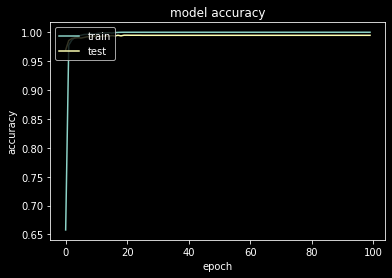

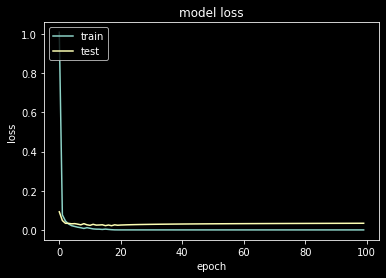

In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

base_model = gravity.get_vgg19(classes=mnist_classes,
                               input_shape=(32, 32, 1),
                               drop_out_rate=0,
                               print_summary=False)
model = gravity.resize_model_input_size(base_model,
                                        target_size=(32, 32),
                                        data_shape=(28, 28, 1),
                                        print_summary=False)

model.compile(optimizer=gravity_opt,
            loss=cost_func,
            metrics=['accuracy'])
history = model.fit(x_train_mnist, y_train_mnist,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_mnist, y_test_mnist))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravity.save_run_info(model,
                     history,
                     gravity_opt,
                     'MNIST',
                     comment=comment)

save_run_info completed


## Fashion MNIST

In [ ]:
fashion_mnist_dict = gravity.get_dataset_fashion_mnist(verbose=False, show_images=False)
x_train_fashion_mnist, y_train_fashion_mnist = fashion_mnist_dict['train_data']
x_test_fashion_mnist, y_test_fashion_mnist = fashion_mnist_dict['test_data']
fashion_mnist_classes = fashion_mnist_dict['classes']
fashion_mnist_input_shape = fashion_mnist_dict['input_shape']

### VGG16

In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

base_model = gravity.get_vgg16(classes=fashion_mnist_classes,
                               input_shape=(32, 32, 1),
                               drop_out_rate=0,
                               print_summary=False)
model = gravity.resize_model_input_size(base_model,
                                        target_size=(32, 32),
                                        data_shape=fashion_mnist_input_shape,
                                        print_summary=False)

model.compile(optimizer=gravity_opt,
            loss=cost_func,
            metrics=['accuracy'])
history = model.fit(x_train_fashion_mnist, y_train_fashion_mnist,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_fashion_mnist, y_test_fashion_mnist))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravity.save_run_info(model,
                     history,
                     gravity_opt,
                     'Fashion MNIST',
                     comment=comment)

save_run_info completed


### VGG19

Epoch 1/100
  2/469 [..............................] - ETA: 40s - loss: 2.3029 - accuracy: 0.0820

469/469 [==============================] - 42s 89ms/step - loss: 1.3161 - accuracy: 0.5050 - val_loss: 0.5353 - val_accuracy: 0.8003
Epoch 2/100
469/469 [==============================] - 41s 87ms/step - loss: 0.4345 - accuracy: 0.8379 - val_loss: 0.4126 - val_accuracy: 0.8439
Epoch 3/100
469/469 [==============================] - 41s 88ms/step - loss: 0.3374 - accuracy: 0.8747 - val_loss: 0.3453 - val_accuracy: 0.8722
Epoch 4/100
469/469 [==============================] - 41s 87ms/step - loss: 0.2929 - accuracy: 0.8893 - val_loss: 0.3348 - val_accuracy: 0.8737
Epoch 5/100
469/469 [==============================] - 41s 87ms/step - loss: 0.2662 - accuracy: 0.9007 - val_loss: 0.2800 - val_accuracy: 0.8994
Epoch 6/100
469/469 [==============================] - 41s 88ms/step - loss: 0.2367 - accuracy: 0.9122 - val_loss: 0.2750 - val_accuracy: 0.9016
Epoch 7/100
469/469 [==============================] - 41s 88ms/step - loss: 0.2169 - accuracy: 0.9199 - val_loss: 0.2868 - val_accuracy: 0.89

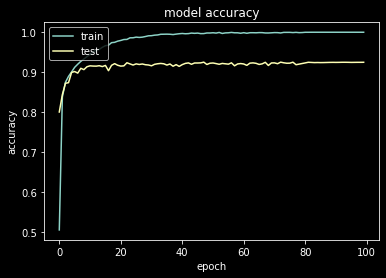

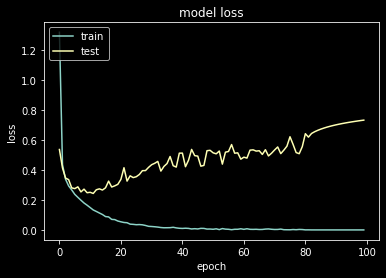

In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

base_model = gravity.get_vgg19(classes=fashion_mnist_classes,
                               input_shape=(32, 32, 1),
                               drop_out_rate=0,
                               print_summary=False)
model = gravity.resize_model_input_size(base_model,
                                        target_size=(32, 32),
                                        data_shape=fashion_mnist_input_shape,
                                        print_summary=False)

model.compile(optimizer=gravity_opt,
            loss=cost_func,
            metrics=['accuracy'])
history = model.fit(x_train_fashion_mnist, y_train_fashion_mnist,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_fashion_mnist, y_test_fashion_mnist))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravity.save_run_info(model,
                     history,
                     gravity_opt,
                     'Fashion MNIST',
                     comment=comment)

save_run_info completed


## CIFAR10

In [ ]:
cifar10_dict = gravity.get_dataset_cifar10(verbose=False, show_images=False)
x_train_cifar10, y_train_cifar10 = cifar10_dict['train_data']
x_test_cifar10, y_test_cifar10 = cifar10_dict['test_data']
cifar10_classes = cifar10_dict['classes']
cifar10_input_shape = cifar10_dict['input_shape']

170500096/170498071 [==============================] - 2s 0us/step


### VGG16

Epoch 1/100
391/391 [==============================] - 29s 74ms/step - loss: 2.1656 - accuracy: 0.1837 - val_loss: 1.9305 - val_accuracy: 0.2886
Epoch 2/100
391/391 [==============================] - 29s 75ms/step - loss: 1.6716 - accuracy: 0.3798 - val_loss: 1.5063 - val_accuracy: 0.4485
Epoch 3/100
391/391 [==============================] - 29s 74ms/step - loss: 1.3654 - accuracy: 0.5006 - val_loss: 1.2478 - val_accuracy: 0.5429
Epoch 4/100
391/391 [==============================] - 29s 74ms/step - loss: 1.1582 - accuracy: 0.5806 - val_loss: 1.1082 - val_accuracy: 0.6030
Epoch 5/100
391/391 [==============================] - 29s 74ms/step - loss: 0.9788 - accuracy: 0.6527 - val_loss: 1.0105 - val_accuracy: 0.6396
Epoch 6/100
391/391 [==============================] - 29s 74ms/step - loss: 0.8258 - accuracy: 0.7083 - val_loss: 0.9779 - val_accuracy: 0.6567
Epoch 7/100
391/391 [==============================] - 29s 74ms/step - loss: 0.6967 - accuracy: 0.7562 - val_loss: 0.8080 - val_ac

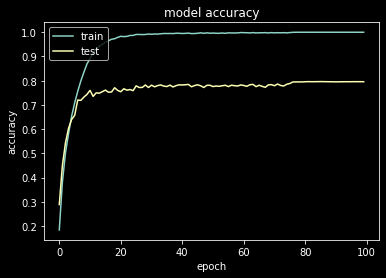

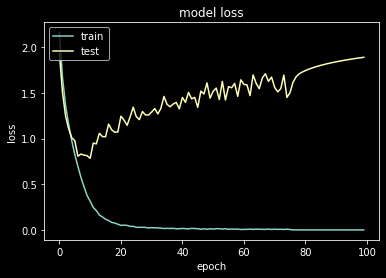

In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = gravity.get_vgg16(classes=cifar10_classes,
                          input_shape=(32, 32, 3),
                          drop_out_rate=0,
                          print_summary=False)

model.compile(optimizer=gravity_opt,
              loss=cost_func,
              metrics=['accuracy'])
history = model.fit(x_train_cifar10, y_train_cifar10,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_cifar10, y_test_cifar10))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravity.save_run_info(model,
                     history,
                     gravity_opt,
                     'CIFAR10',
                     comment=comment)

save_run_info completed


### VGG19


In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = gravity.get_vgg19(classes=cifar10_classes,
                          input_shape=(32, 32, 3),
                          drop_out_rate=0,
                          print_summary=False)

model.compile(optimizer=gravity_opt,
              loss=cost_func,
              metrics=['accuracy'])
history = model.fit(x_train_cifar10, y_train_cifar10,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_cifar10, y_test_cifar10))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravty.save_run_info(model,
                     history,
                     gravity_opt,
                     'CIFAR10',
                     comment=comment)

## CIFAR100 (Coarse)

In [ ]:
cifar100_dict = gravity.get_dataset_cifar100(label_mode='coarse', verbose=True, show_images=True)
x_train_cifar100, y_train_cifar100 = cifar100_dict['train_data']
x_test_cifar100, y_test_cifar100 = cifar100_dict['test_data']
cifar100_classes = cifar100_dict['classes']
cifar100_input_shape = cifar100_dict['input_shape']

### VGG16

In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = gravity.get_vgg16(classes=cifar100_classes,
                          input_shape=(32, 32, 3),
                          drop_out_rate=0,
                          print_summary=False)

model.compile(optimizer=gravity_opt,
              loss=cost_func,
              metrics=['accuracy'])
history = model.fit(x_train_cifar100, y_train_cifar100,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_cifar100, y_test_cifar100))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravity.save_run_info(model,
                     history,
                     gravity_opt,
                     'CIFAR100 (Coarse)',
                     comment=comment)

save_run_info completed


### VGG19


In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = gravity.get_vgg19(classes=cifar100_classes,
                          input_shape=(32, 32, 3),
                          drop_out_rate=0,
                          print_summary=False)

model.compile(optimizer=gravity_opt,
              loss=cost_func,
              metrics=['accuracy'])
history = model.fit(x_train_cifar100, y_train_cifar100,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_cifar100, y_test_cifar100))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravty.save_run_info(model,
                     history,
                     gravity_opt,
                     'CIFAR100 (Coarse)',
                     comment=comment)

## CIFAR100 (Fine)

CIFAR100 dataset information:
  * Total Train Samples: 50000
  * Total Test Samples:  10000
  * Input Shape:  (32, 32, 3)
  * Output Shape: (1,)
Shapes Detail:
  * x_train:  (50000, 32, 32, 3)
  * y_train:  (50000, 1)
  * x_test:   (10000, 32, 32, 3)
  * y_test:   (10000, 1)
Random Train Example: 


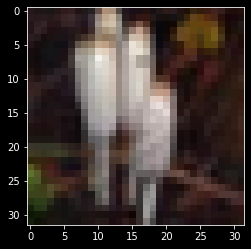

Label: [51]
Random Test Example: 


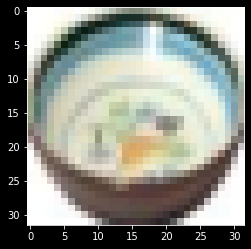

Label: [10]


In [ ]:
cifar100_dict = gravity.get_dataset_cifar100(label_mode='fine', verbose=True, show_images=True)
x_train_cifar100, y_train_cifar100 = cifar100_dict['train_data']
x_test_cifar100, y_test_cifar100 = cifar100_dict['test_data']
cifar100_classes = cifar100_dict['classes']
cifar100_input_shape = cifar100_dict['input_shape']

### VGG16

Epoch 1/100
391/391 [==============================] - 30s 76ms/step - loss: 4.3493 - accuracy: 0.0362 - val_loss: 3.9703 - val_accuracy: 0.0847
Epoch 2/100
391/391 [==============================] - 29s 74ms/step - loss: 3.7991 - accuracy: 0.1072 - val_loss: 3.8313 - val_accuracy: 0.1109
Epoch 3/100
391/391 [==============================] - 29s 74ms/step - loss: 3.5234 - accuracy: 0.1533 - val_loss: 3.3790 - val_accuracy: 0.1878
Epoch 4/100
391/391 [==============================] - 29s 75ms/step - loss: 3.2462 - accuracy: 0.2050 - val_loss: 3.1340 - val_accuracy: 0.2312
Epoch 5/100
391/391 [==============================] - 29s 74ms/step - loss: 2.9889 - accuracy: 0.2534 - val_loss: 3.0208 - val_accuracy: 0.2534
Epoch 6/100
391/391 [==============================] - 29s 74ms/step - loss: 2.7518 - accuracy: 0.2983 - val_loss: 2.8211 - val_accuracy: 0.2980
Epoch 7/100
391/391 [==============================] - 29s 74ms/step - loss: 2.5075 - accuracy: 0.3475 - val_loss: 2.6955 - val_ac

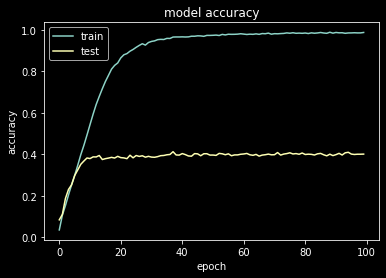

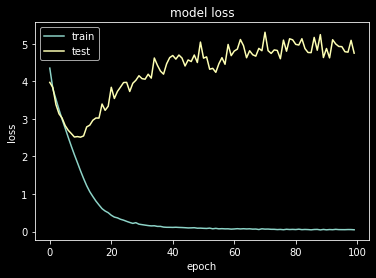

In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = gravity.get_vgg16(classes=cifar100_classes,
                          input_shape=(32, 32, 3),
                          drop_out_rate=0,
                          print_summary=False)

model.compile(optimizer=gravity_opt,
              loss=cost_func,
              metrics=['accuracy'])
history = model.fit(x_train_cifar100, y_train_cifar100,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_cifar100, y_test_cifar100))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravity.save_run_info(model,
                     history,
                     gravity_opt,
                     'CIFAR100 (Fine)',
                     comment=comment)

save_run_info completed


### VGG19


In [ ]:
batch_size = 128
epochs = 100
gravity_opt = Gravity(learning_rate=0.1, alpha=0.01, beta=0.9)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
cost_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = gravity.get_vgg19(classes=cifar100_classes,
                          input_shape=(32, 32, 3),
                          drop_out_rate=0,
                          print_summary=False)

model.compile(optimizer=gravity_opt,
              loss=cost_func,
              metrics=['accuracy'])
history = model.fit(x_train_cifar100, y_train_cifar100,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test_cifar100, y_test_cifar100))
gravity.plot_history(history)

In [ ]:
comment = f"""Batch Size: {batch_size}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = (beta_hat*t+1)/(t+2)'"""
gravty.save_run_info(model,
                     history,
                     gravity_opt,
                     'CIFAR100 (Fine)',
                     comment=comment)